In [29]:
# Basic tools
import feedparser
import re
import string
import enchant
from time import sleep
from collections import Counter
from dateutil.relativedelta import relativedelta

# Logging
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)
logger = logging.getLogger()

# Data science tools
import pandas as pd
import numpy as np

# Viz tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# ML tools
from sklearn.manifold import TSNE

# NLP tools
import gensim
from wordcloud import WordCloud
import nltk
from nltk.metrics import association as nltk_assoc
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

# Spark
import pyspark
from pyspark.sql import functions as sqlf
from pyspark.sql.types import *

[nltk_data] Downloading package punkt to /Users/ross/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ross/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/ross/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ross/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Initialize helper variables
stop_words = set(nltk.corpus.stopwords.words('english'))
punc_trans = str.maketrans('', '', ''.join([x for x in string.punctuation]))
bigram_measures = nltk_assoc.BigramAssocMeasures()
enchant_dict = enchant.Dict("en_US")

In [3]:
def parallel_load_eprints(query = 'cat:hep-th', start_entry = 0, max_step_results = 100, pub_window = relativedelta(years = 1)):
    min_pub_date = pd.to_datetime('today') - pub_window
    "Read eprint data into a Pandas DataFrame iteratively through the arxiv API."  
    # Request data from arxiv API feed until success
    while True:
        url = 'http://export.arxiv.org/api/query?search_query={}&sortBy=submittedDate&sortOrder=descending&start={}&max_results={}'.format(query, start_entry, max_step_results)
        data = feedparser.parse(url)
        if len(data.entries):
            break
        sleep(0.1)
    i = 0
    while i < len(data.entries):
        if pd.to_datetime(data.entries[i].published) <= min_pub_date:
            break
        i += 1
    return data.entries[:i + 1]

In [4]:
def load_eprint_df(query = 'cat:hep-th', max_step_results = 100, spark_context = None, partitions = 1, pub_window = relativedelta(years = 1)):
    "Read eprint data into a Pandas DataFrame iteratively through the arxiv API."  
    min_pub_date = pd.to_datetime('today') - pub_window
    entries = []
    i = 0
    if spark_context:
        rdd = spark_context.parallelize(range(partitions))
        while len(entries) == 0 or pd.to_datetime(entries[-1].published) >= min_pub_date:
            entries += rdd.flatMap(lambda j: parallel_load_eprints(query = query, \
                                                                     start_entry = (i + j) * max_step_results, \
                                                                     max_step_results = max_step_results, \
                                                                     pub_window = pub_window)).collect()
            i += partitions
    else:
        while len(entries) == 0 or pd.to_datetime(entries[-1].published) >= min_pub_date:
            # Request data from arxiv API feed until success
            entries += parallel_load_eprints(query = query, \
                                             start_entry = i * max_step_results, \
                                             max_step_results = max_step_results, \
                                             pub_window = pub_window)
            i += 1
    eprint_df = pd.DataFrame(data = entries)
    eprint_df.published = eprint_df.published.apply(pd.to_datetime)
    eprint_df = eprint_df[eprint_df.published >= min_pub_date]
    return eprint_df[['published', 'title', 'summary']]

In [5]:
def word_tokenize(sentence, delimiter = ' ', stopwords = []):
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.lower()
    sentence = re.sub(r'([a-zA-Z])\-([a-zA-Z])', r'\1' + delimiter + r'\2', sentence)
    sentence = re.sub(r'([^\\])\$(.*?)([^\\])\$', "", sentence)
    sentence = re.sub('\\\\[\'"]', '', sentence)
    word_tokens = nltk.tokenize.word_tokenize(sentence)
    filtered_word_tokens = []
    for word in word_tokens:
        word = word.translate(punc_trans)
        if word.isalpha() and not word in stopwords:
            filtered_word_tokens.append(word)
    return filtered_word_tokens

In [6]:
def sent_tokenize(text, delimiter = ' ', stopwords = []):#stop_words, punc_trans):
    "Remove LaTeX tags, and extra whitespace, stopwords, and non-alphanumeric \
    characters. Make all lower case."
    sentence_tokens = nltk.tokenize.sent_tokenize(text)
    filtered_sentence_tokens = []
    for sentence in sentence_tokens:
        filtered_word_tokens = word_tokenize(sentence,
                                             delimiter = delimiter,
                                             stopwords = stopwords)
        filtered_sentence_tokens.append(filtered_word_tokens)
    return filtered_sentence_tokens

In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_word_tokens(word_tokens):
    lemma_tokens = []
    for word in word_tokens:
        verb_lemma = lemmatizer.lemmatize(word, 'v')
        if verb_lemma == word:
            noun_lemma = lemmatizer.lemmatize(word, 'n')
            lemma_tokens.append(noun_lemma)
        else:
            lemma_tokens.append(verb_lemma)        
    return lemma_tokens

In [8]:
def apply_bigrams(word_bag, bigrams, delimiter = '_'):
    new_word_bag = list(word_bag)
    if len(bigrams) > 0:
        i = 0
        while i <= len(new_word_bag) - 2:
            poten_bigram = tuple(new_word_bag[i:i + 2])
            if poten_bigram in bigrams:
                new_word = delimiter.join(poten_bigram)
                new_word_bag[i] = new_word
                del new_word_bag[i + 1:i + 2]
            i += 1
    return new_word_bag

In [22]:
def process_eprints(eprint_df):
    title_stem_tokens = sc.parallelize(eprint_df.title) \
                          .map(lambda x: stem_word_tokens(word_tokenize(x, delimiter = ' ', stopwords = stop_words))) \
                          .collect()

    p_title_ngram_tokens = title_stem_tokens[:]

    i = 0
    while i < 2 - 1:
        bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents(p_title_ngram_tokens)
        bigram_finder.apply_freq_filter(2)
        bigrams = [x[0] for x in bigram_finder.score_ngrams(bigram_measures.pmi) if not any(x in stop_words for x in x[0])]
        p_title_ngram_tokens = sc.parallelize(p_title_ngram_tokens) \
                               .map(lambda x: apply_bigrams(x, bigrams, delimiter = '')) \
                               .collect()
        i += 1

    fp_title_ngram_tokens = [[y for y in x if not enchant_dict.check(y)] for x in p_title_ngram_tokens]

    p_title = [' '.join(x) for x in p_title_ngram_tokens]
    fp_title = [' '.join(x) for x in fp_title_ngram_tokens]

    eprint_df["p_title"] = pd.Series(p_title, index = eprint_df.index)
    eprint_df["fp_title"] = pd.Series(fp_title, index = eprint_df.index)

    summary_sentence_word_tokens = sc.parallelize(eprint_df.summary) \
                                     .map(lambda x: sent_tokenize(x, delimiter = ' ', stopwords = [])) \
                                     .collect()

    summary_sentence_counts = [len(x) for x in summary_sentence_word_tokens]
    sentence_word_tokens = [x for y in summary_sentence_word_tokens for x in y]

    p_sentence_stem_tokens = sc.parallelize(sentence_word_tokens) \
                                     .map(lambda x: stem_word_tokens(x)) \
                                     .collect()

    p_sentence_ngram_tokens = [x[:] for x in p_sentence_stem_tokens]

    i = 0
    while i < 4 - 1:
        bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents(p_sentence_ngram_tokens)
        bigram_finder.apply_freq_filter(5)
        bigrams = [x[0] for x in bigram_finder.score_ngrams(bigram_measures.pmi) if not any(x in stop_words for x in x[0])]
        p_sentence_ngram_tokens = sc.parallelize(p_sentence_ngram_tokens) \
                                  .map(lambda x: apply_bigrams(x, bigrams, delimiter = '')) \
                                  .collect()
        i += 1

    p_summaries = []
    fp_summaries = []
    i = 0
    for count in summary_sentence_counts:
        p_summary_sentence_ngram_tokens = [x for y in p_sentence_ngram_tokens[i:i + count] for x in y]
        p_summaries.append(' '.join(p_summary_sentence_ngram_tokens))
        fp_summaries.append(' '.join([x for x in p_summary_sentence_ngram_tokens if not enchant_dict.check(x)]))
        i += count

    eprint_df["p_summary"] = pd.Series(p_summaries, index = eprint_df.index)
    eprint_df["fp_summary"] = pd.Series(fp_summaries, index = eprint_df.index)

    i = 0
    j = 0
    summary_id = 0
    sentence_dict = {"summary_id": [], "p_sentence": [], "fp_sentence": []}
    for p_ngram_tokens in p_sentence_ngram_tokens:
        p_sentence = ' '.join(p_ngram_tokens)
        fp_sentence = ' '.join([x for x in p_ngram_tokens if not enchant_dict.check(x)])
        if j < summary_sentence_counts[i]:
            j += 1
        else:
            i += 1
            j = 1
            summary_id += 1
        sentence_dict["summary_id"].append(summary_id)
        sentence_dict["p_sentence"].append(p_sentence)
        sentence_dict["fp_sentence"].append(fp_sentence)

    sentence_df = pd.DataFrame(sentence_dict, columns = list(sentence_dict.keys()))
    
    return eprint_df, sentence_df

In [10]:
sc = pyspark.SparkContext(appName = "arX-Live")
sqlContext = pyspark.sql.SQLContext(sc)

In [16]:
# Obtain 1 year of hep-th arvix eprint data and save
eprint_df = load_eprint_df(query = 'cat:hep-th', \
                           max_step_results = 200, \
                           spark_context = sc, \
                           partitions = 10, \
                           pub_window = relativedelta(years = 1))
eprint_df.to_pickle('../pkl/eprint_df.pkl')

In [23]:
eprint_df = pd.read_pickle('../pkl/eprint_df.pkl')#, index_col = 0)
eprint_df, sentence_df = process_eprints(eprint_df)

In [39]:
word_collection = [y for x in eprint_df.fp_summary for y in x.split()]
word_freqs = Counter(word_collection)
all_words = list(set(word_collection))

window_duration = '30 day'
slide_duration = '1 day'

flatten_udf = sqlf.udf(lambda x: [z for y in x for z in y.split()], ArrayType(StringType()))

spark_eprint_df = sqlContext.createDataFrame(eprint_df)

spark_windows_df = spark_eprint_df.groupBy(sqlf.window("published", window_duration, slide_duration)) \
    .agg(flatten_udf(sqlf.collect_list("fp_summary")).alias('sliding_window')) \
    .sort(sqlf.col("window").asc())

def get_freqs(collection, all_words):
    counter = Counter(collection)
    return [counter[x] for x in all_words]
    
pub_counts = dict(spark_windows_df.rdd.map(lambda x: (x["window"]["end"], get_freqs(x["sliding_window"], all_words))).collect())

norm_word_counts_df = pd.DataFrame(pub_counts, index = all_words).fillna(0)

In [41]:
summary_sentence_ngram_tokens = [x.split() for x in sentence_df.fp_sentence]

model = gensim.models.Word2Vec(summary_sentence_ngram_tokens, size = 100, window = 10, min_count = 5, workers = 4)
model.train(summary_sentence_ngram_tokens, total_examples = len(summary_sentence_ngram_tokens), epochs = 10)
term_vocab = [x for x in model.wv.vocab if not enchant_dict.check(x)]

2018-05-16 15:55:42,756 : INFO : collecting all words and their counts
2018-05-16 15:55:42,758 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-16 15:55:42,771 : INFO : PROGRESS: at sentence #10000, processed 35376 words, keeping 9420 word types
2018-05-16 15:55:42,784 : INFO : PROGRESS: at sentence #20000, processed 71095 words, keeping 12283 word types
2018-05-16 15:55:42,800 : INFO : PROGRESS: at sentence #30000, processed 105860 words, keeping 13872 word types
2018-05-16 15:55:42,812 : INFO : collected 14506 word types from a corpus of 121684 raw words and 34516 sentences
2018-05-16 15:55:42,812 : INFO : Loading a fresh vocabulary
2018-05-16 15:55:42,828 : INFO : min_count=5 retains 7779 unique words (53% of original 14506, drops 6727)
2018-05-16 15:55:42,829 : INFO : min_count=5 leaves 109456 word corpus (89% of original 121684, drops 12228)
2018-05-16 15:55:42,855 : INFO : deleting the raw counts dictionary of 14506 items
2018-05-16 15:55:42,857 

2018-05-16 15:55:44,488 : INFO : EPOCH - 8 : training on 121684 raw words (108453 effective words) took 0.1s, 1171892 effective words/s
2018-05-16 15:55:44,598 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-16 15:55:44,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-16 15:55:44,602 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-16 15:55:44,610 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-16 15:55:44,611 : INFO : EPOCH - 9 : training on 121684 raw words (108456 effective words) took 0.1s, 1007069 effective words/s
2018-05-16 15:55:44,707 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-16 15:55:44,714 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-16 15:55:44,719 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-16 15:55:44,720 : INFO : worker thread finished; awaiting finish of 0 more threads


In [30]:
tsne = TSNE(n_components = 2)

pub_date = norm_word_counts_df.columns[0]
pub_date_counts = norm_word_counts_df[pub_date]
#X = model.wv[pub_date_counts[pub_date_counts > 0].index]
X = model.wv[model.wv.vocab]
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize = (25, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('../imgs/TSNE.png', dpi = 100, bbox_inches = 'tight')

KeyboardInterrupt: 

In [ ]:
tsne = sklearn.decomposition.PCA(n_components = 2)

pub_date = norm_word_counts_df.columns[0]
pub_date_counts = norm_word_counts_df[pub_date]
#X = model.wv[pub_date_counts[pub_date_counts > 0].index]
X = model.wv.vocab
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [21]:
tfidf_vectorizer = sklearn.feature_extraction.textTfidfVectorizer(analyzer = 'word',
                                                                  max_df = 0.8,
                                                                  max_features = 200000,
                                                                  min_df = 0.2,
                                                                  stop_words = 'english',
                                                                  use_idf = True,
                                                                  vocabulary = term_vocab,
                                                                  ngram_range = (1, 1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(summary_sentence_df.fp_sentence)

CPU times: user 176 ms, sys: 3.86 ms, total: 180 ms
Wall time: 180 ms


In [22]:
print(tfidf_matrix.shape)

(34349, 7775)


In [188]:
dictionary = gensim.corpora.Dictionary(eprint_df.title_ngrams)
dictionary.filter_extremes(no_above = 0.8, no_below = 3)
dictionary.compactify()
corpus = [dictionary.doc2bow(x) for x in eprint_df.title_ngrams]

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = dictionary,
                                            num_topics = 100,
                                            update_every = 5,
                                            chunksize = 10000,
                                            passes = 3)

2018-05-16 08:36:31,295 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-05-16 08:36:31,345 : INFO : built Dictionary(2763 unique tokens: ['deformation', 'mechanic', 'quantization', 'quantum', 'constant']...) from 6281 documents (total 26176 corpus positions)
2018-05-16 08:36:31,348 : INFO : discarding 1504 tokens: [('hodge', 2), ('nnnnnnnnlo', 1), ('neuman', 1), ('tolman', 2), ('simply', 2), ('ishibashi', 1), ('bertotti', 1), ('civita', 1), ('levi', 1), ('ultrarelativistic', 1)]...
2018-05-16 08:36:31,349 : INFO : keeping 1259 tokens which were in no less than 3 and no more than 5024 (=80.0%) documents
2018-05-16 08:36:31,350 : INFO : resulting dictionary: Dictionary(1259 unique tokens: ['deformation', 'mechanic', 'quantization', 'quantum', 'constant']...)
2018-05-16 08:36:31,383 : INFO : using symmetric alpha at 0.01
2018-05-16 08:36:31,383 : INFO : using symmetric eta at 0.01
2018-05-16 08:36:31,384 : INFO : using serial LDA version on this node
2018-05-16 08:36:3

In [195]:
[lda_model.id2word[x[0]] for x in lda_model.get_topic_terms(98, topn = 5)]

['effective', 'theory', 'field', 'double', 'string']

In [82]:
dictionary = gensim.corpora.Dictionary([x.split() for x in summary_sentence_df.fp_sentence])
dictionary.filter_extremes(no_above = 0.8, no_below = 3)
dictionary.compactify()
corpus = [dictionary.doc2bow(x.split()) for x in summary_sentence_df.fp_sentence]

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = dictionary,
                                            num_topics = 50,
                                            update_every = 1,
                                            chunksize = 10000,
                                            passes = 1)

2018-05-16 07:26:10,607 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-05-16 07:26:10,684 : INFO : adding document #10000 to Dictionary(9434 unique tokens: ['deformationquantization', 'quantummechanic', 'gaussian', 'loopquantumcosmology', 'probabilitydistribution']...)
2018-05-16 07:26:10,761 : INFO : adding document #20000 to Dictionary(12278 unique tokens: ['deformationquantization', 'quantummechanic', 'gaussian', 'loopquantumcosmology', 'probabilitydistribution']...)
2018-05-16 07:26:10,842 : INFO : adding document #30000 to Dictionary(13877 unique tokens: ['deformationquantization', 'quantummechanic', 'gaussian', 'loopquantumcosmology', 'probabilitydistribution']...)
2018-05-16 07:26:10,878 : INFO : built Dictionary(14481 unique tokens: ['deformationquantization', 'quantummechanic', 'gaussian', 'loopquantumcosmology', 'probabilitydistribution']...) from 34349 documents (total 121603 corpus positions)
2018-05-16 07:26:10,899 : INFO : discarding 5070 tokens: [('d

In [159]:
[lda_model.id2word[x[0]] for x in lda_model.get_topic_terms(0, topn = 5)]

['graviti', 'solut', 'blackhole', 'model', 'higherspin']

In [92]:
lda_model.id2word[139]

'blackhole'

In [23]:
# terms = tfidf_vectorizer.get_feature_names()

In [24]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
from sklearn.cluster import KMeans

n_clusters = 5

km = KMeans(n_clusters = n_clusters)

%time km.fit(tfidf_matrix)

cluster_ids = km.labels_.tolist()

CPU times: user 32.2 s, sys: 1.26 s, total: 33.4 s
Wall time: 9.72 s


In [26]:
summary_sentence_df["cluster_id"] = pd.Series(cluster_ids, index = summary_sentence_df.index)
grouped = summary_sentence_df.groupby('summary_id').aggregate(lambda x: list(x))

In [37]:
sentence_df.cluster_id.value_counts()

1    32763
0      797
2      329
4      232
3      228
Name: cluster_id, dtype: int64

In [43]:
sentence_df.fp_sentence.size

34349

In [44]:
fp_word_clusters = dict([(x, cluster_ids[i]) for i in range(summary_sentence_df.fp_sentence.size) for x in summary_sentence_df.fp_sentence.iloc[i].split()])
fp_words = summary_sentence_df.groupby('summary_id')["fp_sentence"].aggregate(lambda x: [z for y in list(x) for z in y.split()])
cluster_hits = [[fp_word_clusters[y] for y in x] for x in fp_words]

eprint_df["summary_id"] = pd.Series(eprint_df.index, index = eprint_df.index)
eprint_df["fp_words"] = pd.Series(fp_words, index = eprint_df.index)
eprint_df["cluster_hits"] = pd.Series(cluster_hits, index = eprint_df.index)
    
spark_eprint_df = sqlContext.createDataFrame(eprint_df)

In [45]:
eprint_df

,published,summary,summary_id,fp_words,cluster_hits
0,2018-05-15 17:59:36,We analyze the polymer representation of quant...,0,"[quantummechanic, deformationquantization, wig...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2018-05-15 17:54:49,We introduce a novel method to circumvent Wein...,1,"[novelmethod, weinberg, gotheorem, selftune, v...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2018-05-15 17:00:18,We compare the sets of Calabi-Yau threefolds w...,2,"[calabiyauthreefolds, hodgenumber, constructus...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,2018-05-15 16:54:57,We propose a universal mechanism of producing ...,3,"[darkmatter, quaside, keyingredient, darkmatte...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,2018-05-15 16:16:39,Perturbation theory of a large class of scalar...,4,"[perturbationtheory, largeclass, scalarfieldth...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,2018-05-15 16:03:27,We present a new perspective on thermal and qu...,5,"[newperspective, quantumphasetransition, qpt, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."
6,2018-05-15 15:39:33,"In a spin-network basis state, nodes of the gr...",6,"[spinnetwork, un, intertwiner, networkstate, e...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
7,2018-05-15 15:14:22,We study aspects of black holes and quantum ch...,7,"[blackhole, quantumchaos, computationalcost, u...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
8,2018-05-15 11:15:13,We study static massive scalar field condensat...,8,"[massivescalarfield, regularasymptotically, re...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."
9,2018-05-15 10:28:21,"According to the third law of Thermodynamics, ...",9,"[infinitenumber, blackhole, zerotemperature, p...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]"


In [47]:
fp_word_clusters

{'quantummechanic': 1,
 'deformationquantization': 1,
 'wignerfunction': 1,
 'starproduct': 1,
 'schrodinger': 1,
 'weyl': 1,
 'gaussian': 1,
 'probabilitydistribution': 1,
 'loopquantumcosmology': 1,
 'bohr': 1,
 'eventhough': 1,
 'welldefine': 1,
 'alsoderive': 1,
 'generalizeuncertaintyprinciple': 1,
 'minimallength': 1,
 'novelmethod': 1,
 'weinberg': 1,
 'gotheorem': 1,
 'selftune': 1,
 'vacuumenergy': 1,
 'lorentzviolate': 1,
 'finitetemperature': 1,
 'superfluid': 1,
 'arbitrarilylarge': 1,
 'cosmologicalconstant': 1,
 'phenomenologicallyviable': 1,
 'massivegravity': 1,
 'generalrelativity': 1,
 'higherderivative': 1,
 'uv': 1,
 'degravitate': 1,
 'calabiyauthreefolds': 1,
 'hodgenumber': 1,
 'constructuse': 1,
 'toric': 1,
 'hypersurface': 1,
 'ellipticfibrations': 1,
 'weierstrassmodel': 1,
 'ftheory': 1,
 'polytope': 1,
 'tate': 1,
 'threefolds': 1,
 'kreuzer': 1,
 'skarke': 1,
 'weierstrasstate': 1,
 'smallnumber': 1,
 'nontoric': 1,
 'giverise': 1,
 'exoticmatter': 1,
 'ga

In [28]:
word_collection = [x for y in summary_sentence_ngram_tokens for x in y if not enchant_dict.check(x)]
word_freqs = Counter(word_collection)
all_words = list(set(word_collection))

window_duration = '30 day'
slide_duration = '1 day'

find_cluster_id_udf = sqlf.udf(lambda x: [j for i in x for j in grouped.cluster_id.iloc[i]], ArrayType(IntegerType()))

spark_windows_df = spark_eprint_df.groupBy(sqlf.window("published", window_duration, slide_duration)) \
    .agg(find_cluster_id_udf(sqlf.collect_list("summary_id")).alias('sliding_window')) \
    .sort(sqlf.col("window").asc())

In [29]:
def get_freqs(collection):
    counter = Counter(collection)
    return [counter[x] for x in range(n_clusters)]

pub_counts = dict(spark_windows_df.rdd.map(lambda x: (x["window"]["end"], get_freqs(x["sliding_window"]))).collect())

norm_word_counts_df = pd.DataFrame(pub_counts, index = range(n_clusters)).fillna(0)

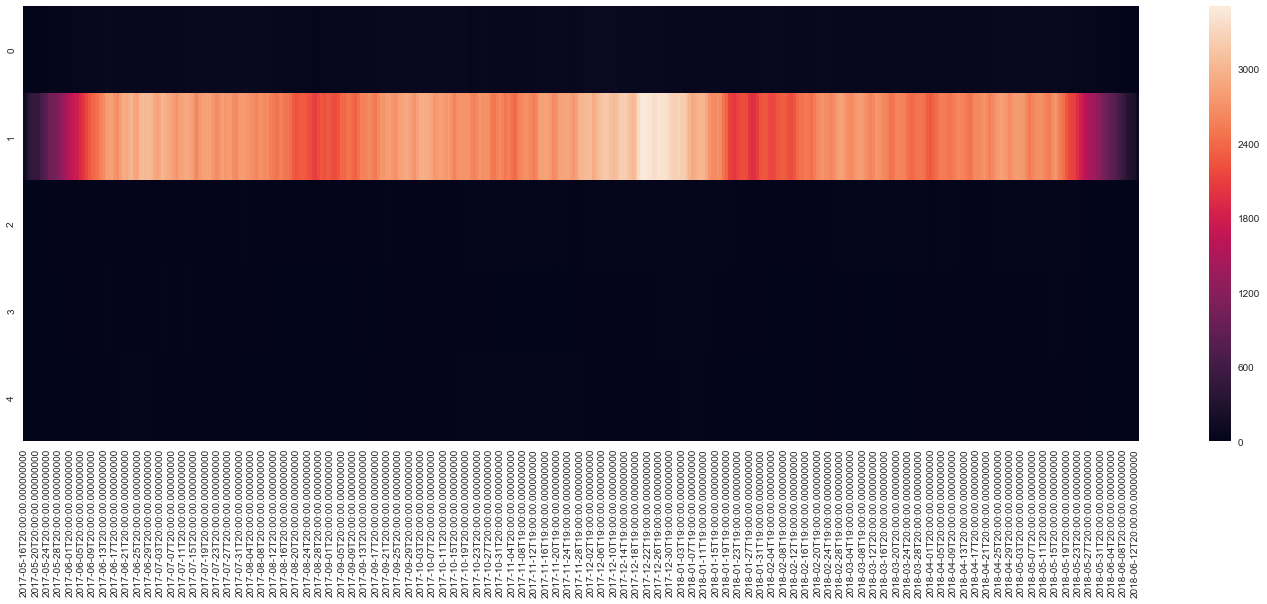

In [30]:
# Plot a (truncated) heatmap for the word frequencies in all 6 month periods
fig, ax = plt.subplots(figsize = (25, 8))
sns.heatmap(norm_word_counts_df, linewidths = 0, annot = False, ax = ax)
plt.show()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('../imgs/heatmap_freq.png', dpi = 100, bbox_inches = 'tight')

In [33]:
summary_sentence_df.groupby('cluster_id')['fp_sentence'].aggregate(lambda x: list(x)).iloc[0]

['blackhole quantumchaos computationalcost unitaries',
 'blackhole analysisshow infalling lyapunovexponent',
 'compactreflectstar blackhole',
 'infinitenumber blackhole zerotemperature',
 'blackhole matterenergy',
 'blackhole upperbind horizonradius',
 'basicproperty spacetime ultrarelativisticlimit blackhole',
 'timedependence gravitationalwavedetector lisa couldprovide blackhole',
 'testparticle gravitationalfield reissnernordstr blackhole antidesitterspacetime circularorbit',
 'circularorbit blackhole cosmologicalconstant massratio testparticle',
 'blackhole secondorderphasetransition',
 'blackhole sufficientlylarge blackhole',
 'blackhole angularmomentum orbitalangularmomentum binaryblackhole',
 'purestate blackhole',
 'blackhole',
 'productionrate primordialblackhole gaussiandistribution cosmologicalperturbation blackhole',
 'newconjecture variousduality blackhole einsteinmaxwell',
 'blackhole lloydbind',
 'blackhole',
 'blackhole flatspacetime horizonless spacetime horizonarea ha

In [ ]:
#sc.stop()